In [2]:
import pandas as pd
import numpy as np
from covid import utils
import matplotlib.pyplot as plt
import seaborn as sns

paths = utils.create_named_tuple('filepaths.txt')
config = utils.create_named_tuple(paths.config)
labels = utils.generate_labels_from_bins(config.age_bins)
bins = config.age_bins
population = pd.read_csv('data/temp_pop.csv')

In [68]:
population

,region_id,region,0-6,7-15,16-20,21-40,41-66,67+,population
0,301,OSLO,55837,64036,33296,257985,207877,77749,696780
1,1101,EIGERSUND,1132,1719,955,3642,4898,2439,14785
2,1103,STAVANGER,11735,16218,8511,41917,47283,18451,144115
3,1106,HAUGESUND,2636,3996,2314,9836,12823,5707,37312
4,1108,SANDNES,7589,10110,5042,22845,25653,9206,80445
...,...,...,...,...,...,...,...,...,...
351,5440,BERLEVÅG,47,61,46,219,341,214,928
352,5441,TANA,166,232,154,624,1052,600,2828
353,5442,NESSEBY,33,86,40,197,295,229,880
354,5443,BÅTSFJORD,150,197,124,622,761,346,2200


In [180]:
pop_eu = pd.read_csv('data/population_europe.csv', delimiter=";")
pop_eu = pop_eu.T.reset_index()
pop_eu.rename({'index': 'age_group', 0: 'population'}, axis=1, inplace=True)
pop_eu.drop(index=16, axis=0, inplace=True)
pop_eu.population = pop_eu.population.apply(lambda x:int(str(x).replace(" ", ""))*1000)
pop_eu['age_low'] = pop_eu.age_group.apply(lambda x: str(x).split("-")[0]).astype(int)
pop_eu['age_high'] = pop_eu.age_group.apply(lambda x: str(x).split("-")[1]).astype(int)
pop_eu.drop('age_group', axis=1, inplace=True)
pop_eu
age = []
age_pop = [] 
for row in pop_eu.iterrows():
    info = row[1]
    age_diff = info.age_high - info.age_low
    for i in range(info.age_low, info.age_high+1):
        age.append(i)
        age_pop.append(info.population/age_diff)
new_pop_eu = pd.DataFrame(np.array([age, age_pop]).T, columns=['age', 'population'])
new_pop_eu.age = new_pop_eu.age.astype(int)
new_pop_eu.population = new_pop_eu.population.astype(int)

In [16]:
df = pd.read_csv('data/contact_data.csv')
df.contact_age_0 = pd.cut(df['contact_age_0'], bins=bins+[110], labels=labels, include_lowest=True)
df.contact_age_1 = pd.cut(df['contact_age_1'], bins=bins+[110], labels=labels, include_lowest=True)
df_mat = pd.DataFrame(df[df.columns[:-2]].groupby(['contact_age_0', 'contact_age_1']).mean()).reset_index()

N_eu = pd.read_csv('data/population_europe_2008.csv')
N_eu.age = pd.cut(N_eu['age'], bins=bins+[110], labels=labels, include_lowest=True)
N_eu = N_eu.groupby('age').sum()['population']
N_eu_tot = N_eu.sum()
N_norway = population[population.columns[2:-1]].sum()
N_norway_tot = np.sum(N_norway)
matrices = []
for col in ['home', 'work', 'school', 'transport', 'leisure']:
    matrix = pd.pivot_table(df_mat, values=col, index='contact_age_0', columns='contact_age_1')
    corrected_matrix = np.zeros((matrix.shape))
    for i, a_i in enumerate(labels):
        for j, a_j in enumerate(labels):
            corrected_matrix[i][j] = matrix[a_i][a_j] * (N_eu_tot * N_norway[a_j])/(N_eu[a_j] * N_norway_tot) # Density correction
    symmetric_matrix = np.zeros((matrix.shape))
    for i, a_i in enumerate(labels):
        for j, a_j in enumerate(labels):
            symmetric_matrix[i][j] = 1/(N_norway[a_i]+N_norway[a_j]) * (corrected_matrix[i][j] * N_norway[a_i] + corrected_matrix[j][i] * N_norway[a_j]) # Symmetry
    matrices.append(symmetric_matrix)

In [25]:
weights = [0,0.3,0.3,0.1,0.2]
combined = np.sum(np.array([np.array(matrices[i])*weights[i] for i in range(len(matrices))]), axis=0)

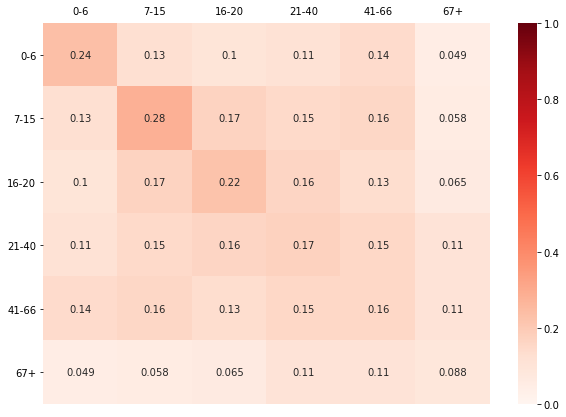

In [26]:
plt.figure(figsize = (10,7))
sns.heatmap(combined, annot=True, vmin=0, vmax=1, cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.yticks(rotation=0)
plt.show()

In [58]:
# Generate data from polymod
contact = pd.read_csv('data/polymod_contact.csv')
hh = pd.read_csv('data/polymod_household.csv')
p = pd.read_csv('data/polymod_participant.csv')
day = pd.read_csv('data/polymod_day.csv')
contact = contact.merge(p.drop('part_gender', axis=1), on='part_id')
contact = contact.merge(hh.drop('hh_size', axis=1), on='hh_id')
contact = contact.merge(day.drop(columns=['sday_id', 'day', 'month', 'year']), on='part_id')
contact.drop(columns=['frequency_multi', 'phys_contact', 'duration_multi', 'cnt_otherplace',
                      'cnt_age_est_min', 'cnt_age_est_max', 'cont_id', 'cnt_gender', 'part_id', 'hh_id'], inplace=True)
contact.dropna(inplace=True)
remap = {
    'cnt_age_exact': int,
    'part_age': int,
    'dayofweek': int,
    'cnt_home': bool,
    'cnt_work': bool,
    'cnt_school': bool,
    'cnt_transport': bool,
    'cnt_leisure': bool
}
contact = contact.astype(remap)
contact = contact[['cnt_age_exact', 'part_age', 'cnt_home', 'cnt_work', 'cnt_school', 'cnt_transport',
       'cnt_leisure', 'country', 'dayofweek']]
def renamer():
    current = ['cnt_age_exact', 'part_age', 'cnt_home', 'cnt_work', 'cnt_school', 'cnt_transport', 'cnt_leisure', 'country', 'dayofweek']
    columns = ['contact_age_0','contact_age_1','home','work','school','transport','leisure','country','dayofweek']
    return {current[i]: columns[i] for i in range(len(current))}
mapper = renamer()
contact.rename(mapper=mapper, axis=1, inplace=True)
contact.sort_values('contact_age_0', inplace=True)

C:\Users\bendikno\Miniconda3\envs\epidemics\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
